In [20]:
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
import scanpy as sc

from ccHBGF import ccHBGF

In [21]:
import clustering_utils

### Lets define our hyperparameters

In [22]:
NSEEDS = 100
RESOLUTION = 8
NWORKERS = 20

ADATA_PATH = '../data/v0.3_clean_control/datasets/glial_raw_embed_propagated.h5ad'

### Lets load the dataset

In [23]:
# adata = sc.read_h5ad(ADATA_PATH, backed='r')
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 259867 × 56939
    obs: 'Author', 'Author_CellType', 'Author_Class_Curated', 'C185_named', 'C25_named', 'C286_named', 'C2_named', 'C465_named', 'C66_named', 'C7_named', 'Cell_ID', 'Dataset', 'Macosko_CellType', 'Region', 'Region_predicted', 'Sample', 'Sample_ID', 'Source', 'Suspension', 'Suspension_bin', 'Technology', 'class_id_label', 'cluster_id_label', 'core', 'is_control', 'nt_type_label', 'pct_mito', 'subclass_id_label', 'supertype_id_label', 'total_counts', 'V1_class_propagated', 'V1_class_confidence', 'ABC_class_propagated', 'ABC_class_confidence', 'major_features', 'major_features_propagated', 'major_features_confidence'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ABC_class_propagated_colors', 'Author_Class_Curated_colors', 'Author_colors', 'Suspension_bin_mapping', 'V1_class_propagated_colors', 'major_features_colors', 'major_features_propagated_colors', 'neighbors', 'tsne', 'umap'
    obsm: 'X_embed', 'X_tsne', 'X_umap'
    ob

### Lets get the adjacency matrix

In [24]:
connectivities_key = adata.uns['neighbors']['connectivities_key']
adata_igraph = sc._utils.get_igraph_from_adjacency(adata.obsp[connectivities_key])

### Lets run the Leiden Community Detection

In [25]:
labels_matrix = np.zeros((adata.shape[0], NSEEDS))

In [26]:
def compute_leiden(seed):
    """Wrapper function for Leiden clustering with a specific random seed."""
    return clustering_utils.igraph_leiden(adata_igraph, RESOLUTION, random_state=seed)

# Initialize a pool of processes
with ProcessPoolExecutor(max_workers=NWORKERS) as executor:
    results = executor.map(compute_leiden, range(NSEEDS))

# Populate the labels_matrix with the results
for i, labels in enumerate(results):
    labels_matrix[:, i] = labels

### Lets check for singleton clusters

In [27]:
def get_singleton_mask(arr, count_treshold):
    
    mask = np.zeros_like(arr, dtype=bool)

    # Any cluster with < count_threshold is a singleton
    for col_idx in range(arr.shape[1]):

        unique_values, counts = np.unique(arr[:, col_idx], return_counts=True)
        value_counts = dict(zip(unique_values, counts))
        
        for value, count in value_counts.items():
            if count < count_treshold:
                mask[:, col_idx] |= (arr[:, col_idx] == value)

    # If a cells is always within a singleton, then flag it
    final_mask = np.any(mask, axis=1)
    
    return final_mask

In [ ]:
singleton_mask = get_singleton_mask(labels_matrix, count_treshold=3)

# How many singletons exist?
n_singletons = sum(singleton_mask)
f"{n_singletons} singletons identified!"

'12 identified!'

### Lets run the consensus clustering

In [29]:
consensus_labels = np.full(adata.shape[0], fill_value=np.nan)
consensus_labels[~singleton_mask] = ccHBGF(labels_matrix[~singleton_mask], random_state=0, verbose=True)

ccHBGF - 17:15:14: Detected 129 clusters.
ccHBGF - 17:15:33: Graph adjacency matrix (A) constructed with shape (259855, 12187)
ccHBGF - 17:15:40: Transformed A to Laplacian Matrix (L) of shape (259855, 12187)
ccHBGF - 17:17:00: Decomposed L into Singular Values (SVs)
ccHBGF - 17:17:00: Normalized SVs
ccHBGF - 17:17:02: Initialized Centers
ccHBGF - 17:17:02: Orthogonalized Centers
ccHBGF - 17:17:04: KMeans model fitted to UVt
ccHBGF - 17:17:04: Consensus Labels Found


In [30]:
leiden_label = f'consensus_leiden_r{RESOLUTION:.0f}'
adata.obs[leiden_label] = pd.Categorical(consensus_labels)

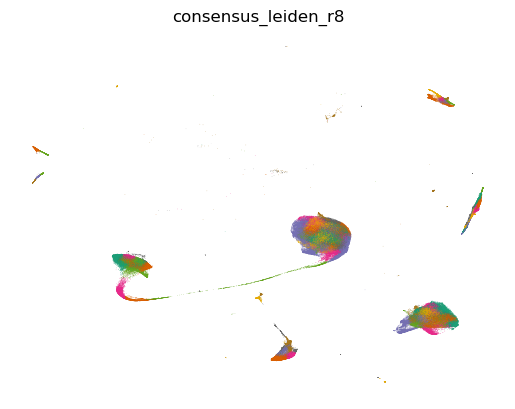

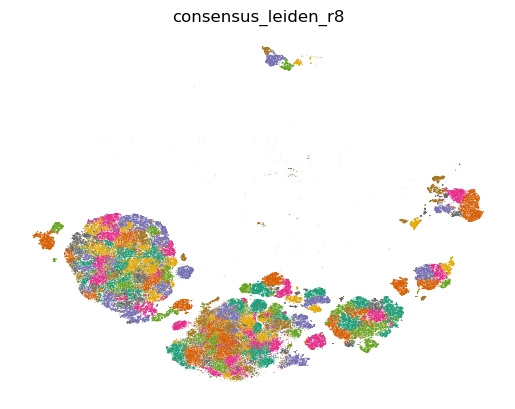

In [31]:
sc.pl.umap(adata, color=leiden_label, frameon=False, palette='Dark2', legend_loc=None)
sc.pl.tsne(adata, color=leiden_label, frameon=False, palette='Dark2', legend_loc=None)

In [ ]:
for key in adata.uns_keys():
    if 'color' in key:
        del adata.uns[key]

In [34]:
adata.write('../data/v0.3_clean_control/datasets/glial_raw_embed_clustered.h5ad')